![Movetru logo](../data/images/logo.webp)
# Gait event detection demo

This workbook contains a demo outlining a proof of concept for the gait event detection algorithm developed for the Movetru "Stage 2 Interview – Sports Biomechanics Data
Scientist Task". A complete brief is available in the parent directory as `brief.pdf`.

This notebook serves the purpose of explaining the algorithms and their implementation details, which are implemented in a more production-ready manner in the web app accompanying this work, which can be found [here](https://github.com/movetru/movetru-webapp).

In this notebook, the user selects the IMU data to use (choosing the participant and trial), explores the data, and runs the detection algorithm on it. 

The sample data used throughout this work comes from the dataset provided by [Grouvel et al., 2023](https://www-nature-com.eux.idm.oclc.org/articles/s41597-023-02077-3). 

The event detection algorithms are inspired by the works of [Hsu et al., 2014](https://ieeexplore-ieee-org.eux.idm.oclc.org/document/6824156) and [Brasiliano et al., 2023](https://www.mdpi.com/2072-666X/14/2/277).

## 1. Exploratory data analysis

Import the data for for a chosen participant, session and trial:

In [347]:
import polars as pl

# Participants available: P01-P10
participant = "P06"
# Sessions available: S01
session = "S01"
# Trials available: SlowGait, Gait, FastGait, Running
trial = "Gait"
# Trial IDs available: varies per trial. Here I use "01" as an example.
trial_id = "01"

# Load the data
sample_df = pl.read_csv(f"../data/synchronised/{participant}_{session}_{trial}_{trial_id}.csv")

We'll focus on the gyroscope data from the feet IMUs in the medial-lateral direction (which corresponds to the y-axis of the IMU), as this is the focus of the event detection algorithm. 

In [348]:
left_foot = sample_df["P6_LF_gyro_y"]
right_foot = sample_df["P6_RF_gyro_y"]

Plot the signals to visualize the data:

Text(0, 0.5, 'Ang. velocity (deg/s)')

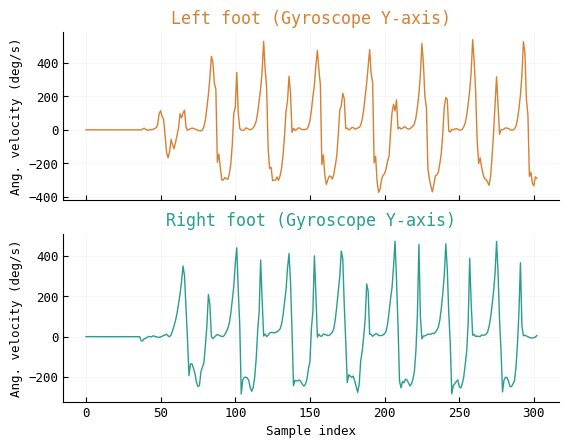

In [349]:
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("movetru.mplstyle")
colours = plt.rcParams['axes.prop_cycle'].by_key()['color']

# Calculate time values for the x-axis based on the sampling frequency
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(left_foot, label="Left Foot Gyro Y", color=colours[0])
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
# ax[0].set_xlim([100, 200])

ax[1].plot(right_foot, label="Right Foot Gyro Y", color=colours[1])
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")

## 2. Data cleaning

Although the data appears relatively clean and expectedly cyclic in nature, the event detection algorithm relies on the detection of local minima in the signal, which can be affected by high frequency noise.

As such, we'll explore the application of a low-pass Butterworth filter using a cutoff frequency determined from analysis of the Fast Fourier Transform (FFT) of the signals, so that we can remove some of the higher frequency harmonics and preserve the first couple of fundamental frequencies.
<!-- 
First, we'll visualise the frequency content of the signals using a FFT, to determine a suitable cutoff frequency for the low-pass filter.

The chosen filtering frequency may seem aggressive, however this is to allow for reliable detection of local peaks, without higher order harmonics interfering. -->

In [350]:
import numpy as np
from scipy.signal import find_peaks as scipy_find_peaks

# Calculate FFT for left foot and right foot signals
fft_left_foot = np.fft.fft(left_foot)
fft_right_foot = np.fft.fft(right_foot)

# Calculate the corresponding frequencies
fs = 100
freqs = np.fft.fftfreq(len(left_foot), d=1/fs)

# Work with positive frequencies only
positive_freqs = freqs[:len(freqs)//2]
left_magnitude = np.abs(fft_left_foot)[:len(freqs)//2]
right_magnitude = np.abs(fft_right_foot)[:len(freqs)//2]

Now from the FFT we'll estimate the first fundamental frequency:

In [351]:

# First pass: find the fundamental frequency (strongest low-frequency peak)
# This will help us set the minimum distance between harmonics
min_peak_height = 0.1  # Peaks must be at least 10% of max amplitude

# Find initial peaks without distance constraint to identify fundamental
initial_left_peaks, _ = scipy_find_peaks(
    left_magnitude, 
    height=np.max(left_magnitude) * min_peak_height
)
initial_right_peaks, _ = scipy_find_peaks(
    right_magnitude, 
    height=np.max(right_magnitude) * min_peak_height
)

# Find the strongest peak in the low-frequency range (likely the fundamental)
# Typical gait frequencies are 0.5-3 Hz, so we look up to ~5 Hz to be safe
low_freq_mask_left = positive_freqs[initial_left_peaks] < 5
low_freq_mask_right = positive_freqs[initial_right_peaks] < 5

# Extract low-frequency peaks for left foot
if np.any(low_freq_mask_left):
    low_freq_peaks_left = initial_left_peaks[low_freq_mask_left]
    low_freq_magnitudes_left = left_magnitude[low_freq_peaks_left]
    strongest_idx_left = np.argmax(low_freq_magnitudes_left)
    fundamental_left = positive_freqs[low_freq_peaks_left[strongest_idx_left]]
else:
    fundamental_left = 1.0

# Extract low-frequency peaks for right foot
if np.any(low_freq_mask_right):
    low_freq_peaks_right = initial_right_peaks[low_freq_mask_right]
    low_freq_magnitudes_right = right_magnitude[low_freq_peaks_right]
    strongest_idx_right = np.argmax(low_freq_magnitudes_right)
    fundamental_right = positive_freqs[low_freq_peaks_right[strongest_idx_right]]
else:
    fundamental_right = 1.0

# Use the average fundamental frequency to set minimum distance
fundamental_freq = (fundamental_left + fundamental_right) / 2
print(fundamental_freq)


2.9702970297029703


And now we'll use the first fundamental frequency as the basis to find higher order harmonics:

In [352]:
# Convert fundamental frequency to minimum peak distance in Hz
# Peaks should be at least ~0.6 * fundamental apart (to avoid picking up sub-harmonics)
min_peak_distance = fundamental_freq

# Second pass: find peaks with appropriate spacing based on the fundamental frequency
left_peaks, _ = scipy_find_peaks(
    left_magnitude, 
    height=np.max(left_magnitude) * min_peak_height,
    distance=min_peak_distance
)
right_peaks, _ = scipy_find_peaks(
    right_magnitude, 
    height=np.max(right_magnitude) * min_peak_height,
    distance=min_peak_distance
)

# Get the frequencies and magnitudes of the peaks
left_peak_freqs = positive_freqs[left_peaks]
left_peak_mags = left_magnitude[left_peaks]
right_peak_freqs = positive_freqs[right_peaks]
right_peak_mags = right_magnitude[right_peaks]

# Sort by magnitude (strongest first)
left_sorted_idx = np.argsort(left_peak_mags)[::-1]
right_sorted_idx = np.argsort(right_peak_mags)[::-1]


Use this to select a signal cutoff frequency that will preserve underlying motion while removing high order frequencies.

In [353]:
# Select cutoff based on top N harmonics
n_harmonics_to_keep = 3  # Adjust this: 1 (most aggressive), 2-3 (balanced), 4+ (less aggressive)

# Get the top N frequencies from both feet
top_n_left = left_peak_freqs[left_sorted_idx[:n_harmonics_to_keep]]
top_n_right = right_peak_freqs[right_sorted_idx[:n_harmonics_to_keep]]
all_top_freqs = np.concatenate([top_n_left, top_n_right])
max_cutoff = np.max(all_top_freqs) + 1  # Add 1 Hz buffer

print(f"\nTop {n_harmonics_to_keep} dominant frequencies:")
print(f"  Left:  {sorted(top_n_left)}")
print(f"  Right: {sorted(top_n_right)}")
print(f"\n✓ Cutoff frequency: {max_cutoff:.1f} Hz")


Top 3 dominant frequencies:
  Left:  [np.float64(2.9702970297029703), np.float64(5.6105610561056105), np.float64(8.58085808580858)]
  Right: [np.float64(2.9702970297029703), np.float64(5.6105610561056105), np.float64(11.551155115511552)]

✓ Cutoff frequency: 12.6 Hz


And finally we can visualise the detected peaks on the FFT:

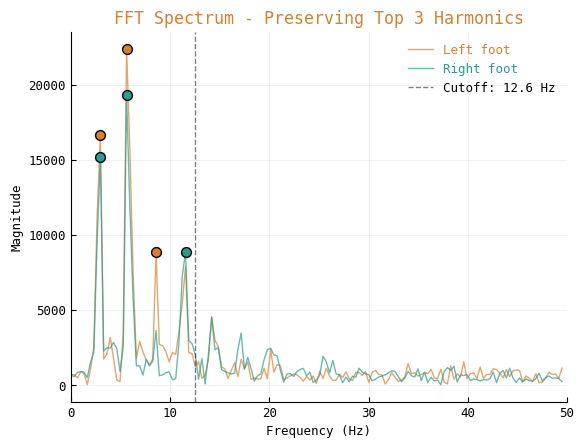

In [354]:
# Plot FFT with selected harmonics marked
plt.figure()
plt.plot(positive_freqs, left_magnitude, label="Left foot", alpha=0.7, color=colours[0])
plt.plot(positive_freqs, right_magnitude, label="Right foot", alpha=0.7, color=colours[1])

# Mark the top N harmonics that will be preserved
plt.scatter(top_n_left, left_magnitude[left_peaks[left_sorted_idx[:n_harmonics_to_keep]]], 
           color=colours[0], s=50, marker='o', edgecolors='black', linewidths=1, zorder=5)
plt.scatter(top_n_right, right_magnitude[right_peaks[right_sorted_idx[:n_harmonics_to_keep]]], 
           color=colours[1], s=50, marker='o', edgecolors='black', linewidths=1, zorder=5)

# Mark the cutoff
plt.axvline(max_cutoff, color='black', linestyle='--', linewidth=1, alpha=0.5, 
           label=f'Cutoff: {max_cutoff:.1f} Hz')

plt.xlim(0, 50)
plt.title(f"FFT Spectrum - Preserving Top {n_harmonics_to_keep} Harmonics")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

By choosing the cutoff frequency based on the fundamental frequencies as opposed to using a fixed threshold, the method becomes applicable to gait cycles independent of speed, since it will always detect the first fundamental frequency, and eliminate prohibiting higher order frequencies. 

We can verify that this is the case by plotting the filtered frequency, where we see that the double troughs in the local minima are smoothed to one trough.

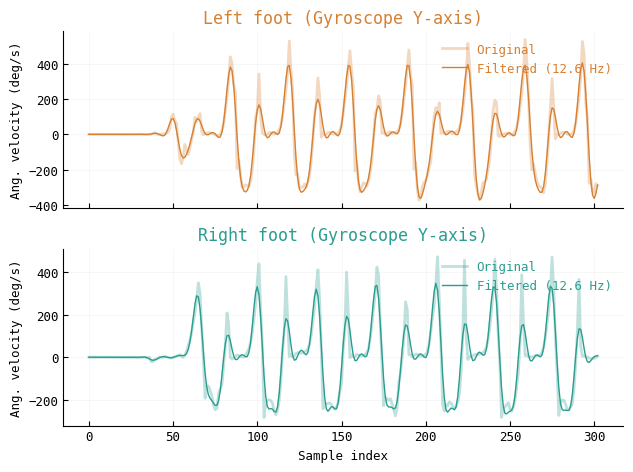

Filter applied: 4th order Butterworth low-pass at 12.6 Hz


In [355]:
from scipy.signal import butter, filtfilt

# Design Butterworth low-pass filter
def butter_lowpass_filter(data, cutoff, fs, order=4):
    """Apply a Butterworth low-pass filter to the data"""
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = filtfilt(b, a, data)
    return filtered_data

# Apply filter to both feet
left_foot_filtered = butter_lowpass_filter(left_foot, max_cutoff, fs, order=4)
right_foot_filtered = butter_lowpass_filter(right_foot, max_cutoff, fs, order=4)

# Plot original and filtered signals
fig, ax = plt.subplots(2, 1, sharex=True)

# Left foot
ax[0].plot(left_foot, label="Original", color=colours[0], alpha=0.3, linewidth=2)
ax[0].plot(left_foot_filtered, label=f"Filtered ({max_cutoff:.1f} Hz)", color=colours[0], linewidth=1)
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper right')
# ax[0].set_xlim(100, 200)
# ax[0].set_ylim(-400, 1000)

# Right foot
ax[1].plot(right_foot, label="Original", color=colours[1], alpha=0.3, linewidth=2)
ax[1].plot(right_foot_filtered, label=f"Filtered ({max_cutoff:.1f} Hz)", color=colours[1], linewidth=1)
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper right')
# ax[1].set_xlim(100, 200)
# ax[1].set_ylim(-400, 1000)
plt.tight_layout()
plt.show()

print(f"Filter applied: 4th order Butterworth low-pass at {max_cutoff:.1f} Hz")

## 3. Event detection

The filtered data now follows a clear trend: each local minima is followed by two local maxima.

From the typical healthy gait cycle, these minima correspond to the time between the foot off and foot contact events.

![Gait cycle](../data/images/typical_gait.png)

The local minima can therefore be used as an anchor from which to search to the left (for peaks corresponding to foot offs) and right (for zero-crossings corresponding to foot contacts).

The conditions for a local minima are:
$$\omega(t) < \omega(t-\Delta t) \text{ and } \omega(t)<\omega(t+ \Delta t) \text{ and } \omega(t)<std(\omega)$$

Using these conditions, we'll search for the local minima using scipy's find_peaks method:

In [356]:
from scipy.signal import find_peaks

# Detect peaks (negative peaks for foot strikes)
peaks_left, _ = find_peaks(-left_foot_filtered, height=np.std(left_foot_filtered), distance=n_harmonics_to_keep*fundamental_freq)
peaks_right, _ = find_peaks(-right_foot_filtered, height=np.std(right_foot_filtered), distance=n_harmonics_to_keep*fundamental_freq)

print(f"Detected {len(peaks_left)} left foot peaks")
print(f"Detected {len(peaks_right)} right foot peaks")

Detected 7 left foot peaks
Detected 7 right foot peaks


And we can visiualize the detected events on the original signal:

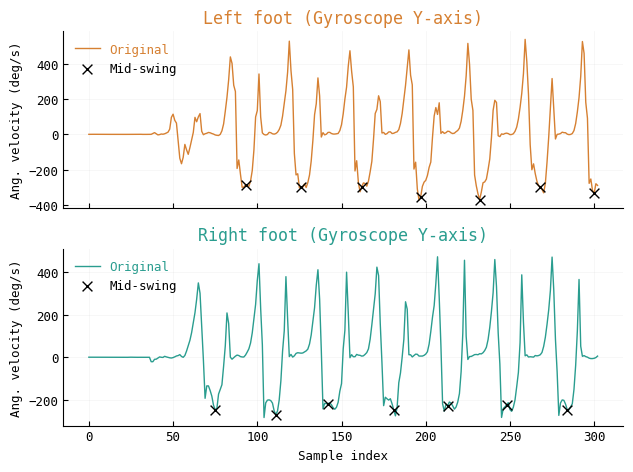

In [357]:
# Plot original signal with detected peaks
fig, ax = plt.subplots(2, 1, sharex=True)

# Left foot
ax[0].plot(left_foot, label=f"Original", color=colours[0], linewidth=1)
ax[0].scatter(peaks_left, left_foot[peaks_left], color='black', s=50, zorder=5, label='Mid-swing', marker='x')
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper left')

# Right foot
ax[1].plot(right_foot, label=f"Original", color=colours[1], linewidth=1)
ax[1].scatter(peaks_right, right_foot[peaks_right], color='black', s=50, zorder=5, label='Mid-swing', marker='x')
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper left')
plt.tight_layout()
plt.show()

### Foot Contact (Heel Strike) Detection

Using the detected mid-swing peaks, we can search forward to find the foot contact events. The foot contact occurs when the angular velocity changes sign (from negative to positive) after the mid-swing peak, which corresponds to the following conditions being met:

$$ \omega(t) \cdot \omega(t - \Delta t) < 0 \text{ and } \omega(t) > \omega(t - \Delta t)
$$

Using these conditions, we can search forward from each mid-swing peak to find the foot contact events:

Detected 6 left foot contacts
Detected 7 right foot contacts


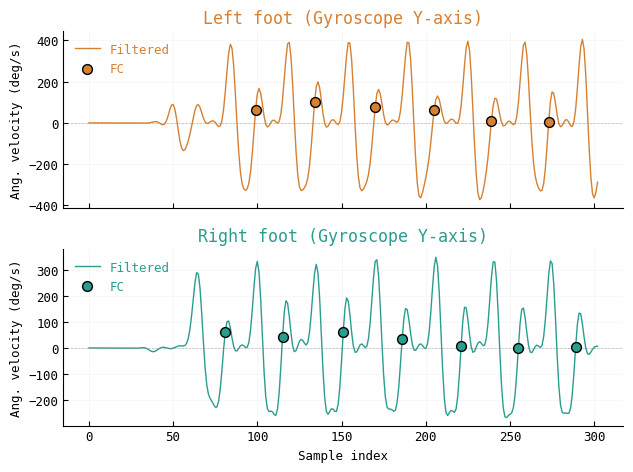

In [358]:
def detect_foot_contact(signal, mid_swing_peaks):
    """
    Detect foot contact events by searching forward from mid-swing peaks.
    Foot contact occurs when: signal[k] * signal[k-1] < 0 AND signal[k] > signal[k-1]
    """
    # Insert a fake mid-swing peak to comply array dimensions
    locs = np.insert(mid_swing_peaks, mid_swing_peaks.shape[0], signal.shape[0])

    FC = [ ]

    for i in range(0, locs.shape[0]):
        for k in range(locs[i-1], locs[i]):
            if (signal[k] * signal[k-1] < 0) and signal[k] > 0:
                FC.append(k)
                break

    return np.array(FC)

# Detect foot contact for both feet
FC_left = detect_foot_contact(left_foot_filtered, peaks_left)
FC_right = detect_foot_contact(right_foot_filtered, peaks_right)

print(f"Detected {len(FC_left)} left foot contacts")
print(f"Detected {len(FC_right)} right foot contacts")

# Plot filtered signal with mid-swing peaks and foot contacts
fig, ax = plt.subplots(2, 1, sharex=True)

# Left foot
ax[0].plot(left_foot_filtered, label=f"Filtered", color=colours[0])
ax[0].scatter(FC_left, left_foot_filtered[FC_left], s=50, zorder=5, 
             label='FC', marker='o', edgecolors='black', color=colours[0], linewidths=1)
ax[0].axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper left')

# Right foot
ax[1].plot(right_foot_filtered, label=f"Filtered", color=colours[1])
ax[1].scatter(FC_right, right_foot_filtered[FC_right], s=50, zorder=5, 
             label='FC', marker='o', edgecolors='black', color=colours[1], linewidths=1)
ax[1].axhline(y=0, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

### Foot Off (Toe-Off) Detection

The foot off event occurs when the foot leaves the ground and begins the swing phase. We search **backwards** from each mid-swing peak to find the local maximum where the angular velocity is at its peak before transitioning to the swing phase.

$$ \omega(t) > \omega(t - \Delta t) \text{ and } \omega(t) > \omega(t + \Delta t) \text{ and } \omega(t) > std(\omega) $$

Using these conditions, we can search backwards from each mid-swing peak to find the foot off events:

Detected 7 left foot offs
Detected 7 right foot offs


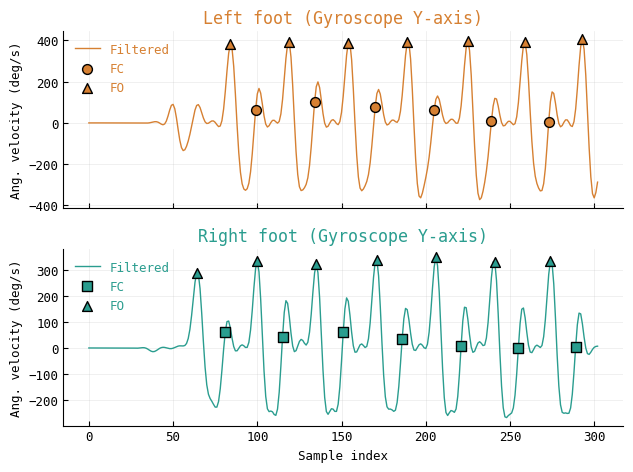

Gait Events Summary:
Left foot:  6 contacts, 7 offs, 7 mid-swings
Right foot: 7 contacts, 7 offs, 7 mid-swings


In [359]:
def detect_foot_off(signal, mid_swing_peaks):
    """
    Detect foot off events by searching backwards from mid-swing peaks.
    Foot off occurs at the local maximum before mid-swing where:
    signal[k] > signal[k-1] AND signal[k] > signal[k+1] AND signal[k] > std(signal)
    """
    FO = []
    
    # Insert fake peaks at start and end to comply with array dimensions
    locs = np.insert(mid_swing_peaks, 0, 0)
    locs = np.insert(locs, locs.shape[0], signal.shape[0] - 2)
    
    for i in range(0, locs.shape[0]):
        # Search backwards from current peak to previous peak
        for k in range(locs[i], locs[i-1], -1):
            # Check for local maximum above standard deviation threshold
            if (signal[k] > signal[k-1]) and (signal[k] > signal[k+1]) and (signal[k] > np.std(signal)):
                FO.append(k)
                break
    
    return np.array(FO)

# Detect foot off for both feet
FO_left = detect_foot_off(left_foot_filtered, peaks_left)
FO_right = detect_foot_off(right_foot_filtered, peaks_right)

print(f"Detected {len(FO_left)} left foot offs")
print(f"Detected {len(FO_right)} right foot offs")

# Plot filtered signal with all gait events
fig, ax = plt.subplots(2, 1, sharex=True)

# Left foot
ax[0].plot(left_foot_filtered, label=f"Filtered", color=colours[0])
ax[0].scatter(FC_left, left_foot_filtered[FC_left], s=50, zorder=5, 
             label='FC', marker='o', edgecolors='black', color=colours[0], linewidths=1)
ax[0].scatter(FO_left, left_foot_filtered[FO_left], color=colours[0], s=50, zorder=5, 
             label='FO', marker='^', edgecolors='black', linewidths=1)
ax[0].set_title("Left foot (Gyroscope Y-axis)")
ax[0].set_ylabel("Ang. velocity (deg/s)")
ax[0].legend(loc='upper left')
ax[0].grid(True, alpha=0.3)

# Right foot
ax[1].plot(right_foot_filtered, label=f"Filtered", color=colours[1], linewidth=1)
ax[1].scatter(FC_right, right_foot_filtered[FC_right], color=colours[1], s=50, zorder=5, 
             label='FC', marker='s', edgecolors='black', linewidths=1)
ax[1].scatter(FO_right, right_foot_filtered[FO_right], color=colours[1], s=50, zorder=5, 
             label='FO', marker='^', edgecolors='black', linewidths=1)
ax[1].set_title("Right foot (Gyroscope Y-axis)", color=colours[1])
ax[1].set_xlabel("Sample index")
ax[1].set_ylabel("Ang. velocity (deg/s)")
ax[1].legend(loc='upper left')
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Gait Events Summary:")
print(f"Left foot:  {len(FC_left)} contacts, {len(FO_left)} offs, {len(peaks_left)} mid-swings")
print(f"Right foot: {len(FC_right)} contacts, {len(FO_right)} offs, {len(peaks_right)} mid-swings")

## 4. Metrics

Now that we have detected the gait events (foot contact, foot off, and mid-swing), we can calculate clinically relevant metrics to assess both **performance** and **injury risk**.

### 4.1 Temporal Metrics (Performance)

These metrics describe the timing characteristics of the gait cycle and are key indicators of movement efficiency and speed.

In [298]:
def calculate_temporal_metrics(FC, FO, fs=100):
    """
    Calculate temporal gait metrics from foot contact (FC) and foot off (FO) events.
    
    Parameters:
    -----------
    FC : array
        Indices of foot contact events
    FO : array
        Indices of foot off events
    fs : int
        Sampling frequency (Hz)
    
    Returns:
    --------
    dict : Dictionary containing temporal metrics
    """
    metrics = {}
    
    # Stride time: time between consecutive foot contacts of the same foot
    stride_times = np.diff(FC) / fs
    metrics['stride_time_mean'] = np.mean(stride_times)
    metrics['stride_time_std'] = np.std(stride_times)
    metrics['stride_times'] = stride_times
    
    # Stance time: time from foot contact to foot off
    # Match FC and FO events (FO should occur after FC)
    stance_times = []
    for fc in FC:
        # Find the next FO event after this FC
        next_fo = FO[FO > fc]
        if len(next_fo) > 0:
            stance_times.append((next_fo[0] - fc) / fs)
    stance_times = np.array(stance_times)
    metrics['stance_time_mean'] = np.mean(stance_times)
    metrics['stance_time_std'] = np.std(stance_times)
    metrics['stance_times'] = stance_times
    
    # Swing time: time from foot off to next foot contact
    swing_times = []
    for i, fo in enumerate(FO[:-1]):
        # Find the next FC event after this FO
        next_fc = FC[FC > fo]
        if len(next_fc) > 0:
            swing_times.append((next_fc[0] - fo) / fs)
    swing_times = np.array(swing_times)
    metrics['swing_time_mean'] = np.mean(swing_times)
    metrics['swing_time_std'] = np.std(swing_times)
    metrics['swing_times'] = swing_times
    
    # Cadence: steps per minute
    metrics['cadence'] = 60 / metrics['stride_time_mean']
    
    # Stance/Swing ratio
    metrics['stance_swing_ratio'] = metrics['stance_time_mean'] / metrics['swing_time_mean']
    
    # Duty factor: stance time as proportion of stride time
    metrics['duty_factor'] = metrics['stance_time_mean'] / metrics['stride_time_mean']
    
    return metrics

# Calculate metrics for both feet
metrics_left = calculate_temporal_metrics(FC_left, FO_left, fs)
metrics_right = calculate_temporal_metrics(FC_right, FO_right, fs)

print("=" * 70)
print("TEMPORAL METRICS (Performance Indicators)")
print("=" * 70)
print(f"\n{'Metric':<25} {'Left Foot':>15} {'Right Foot':>15} {'Unit':>10}")
print("-" * 70)
print(f"{'Stride Time':<25} {metrics_left['stride_time_mean']:>15.3f} {metrics_right['stride_time_mean']:>15.3f} {'s':>10}")
print(f"{'Stance Time':<25} {metrics_left['stance_time_mean']:>15.3f} {metrics_right['stance_time_mean']:>15.3f} {'s':>10}")
print(f"{'Swing Time':<25} {metrics_left['swing_time_mean']:>15.3f} {metrics_right['swing_time_mean']:>15.3f} {'s':>10}")
print(f"{'Cadence':<25} {metrics_left['cadence']:>15.1f} {metrics_right['cadence']:>15.1f} {'steps/min':>10}")
print(f"{'Stance/Swing Ratio':<25} {metrics_left['stance_swing_ratio']:>15.2f} {metrics_right['stance_swing_ratio']:>15.2f} {'':>10}")
print(f"{'Duty Factor':<25} {metrics_left['duty_factor']:>15.3f} {metrics_right['duty_factor']:>15.3f} {'':>10}")
print("=" * 70)

TEMPORAL METRICS (Performance Indicators)

Metric                          Left Foot      Right Foot       Unit
----------------------------------------------------------------------
Stride Time                         0.660           0.647          s
Stance Time                         0.384           0.389          s
Swing Time                          0.273           0.271          s
Cadence                              90.9            92.7  steps/min
Stance/Swing Ratio                   1.41            1.43           
Duty Factor                         0.582           0.601           


In [299]:
# Debug: Check the actual sampling frequency
print("🔍 DEBUGGING SAMPLING FREQUENCY")
print("=" * 70)
print(f"Current fs assumption: {fs} Hz")
print(f"Total samples in data: {len(left_foot)}")
print(f"Total duration (assuming 100Hz): {len(left_foot) / 100:.2f}s")
print(f"Number of strides detected: {len(FC_left) - 1}")
print(f"\nAll columns in dataframe:")
print(sample_df.columns)
print(f"\nLet's check for a time/timestamp column...")
time_cols = [col for col in sample_df.columns if 'time' in col.lower() or 'timestamp' in col.lower()]
print(f"Time columns found: {time_cols}")

if time_cols:
    time_col = time_cols[0]
    print(f"\nTime column data (first 10 rows):")
    print(sample_df[time_col][:10])
    print(f"\nTime column data (last 10 rows):")
    print(sample_df[time_col][-10:])
    
    # Calculate actual sampling rate from time column
    time_values = sample_df[time_col].to_numpy()
    time_diffs = np.diff(time_values)
    actual_fs = 1 / np.mean(time_diffs)
    print(f"\n🎯 ACTUAL SAMPLING FREQUENCY from time column: {actual_fs:.1f} Hz")
    print(f"   Mean time between samples: {np.mean(time_diffs):.6f}s")
    
print("=" * 70)

🔍 DEBUGGING SAMPLING FREQUENCY
Current fs assumption: 50 Hz
Total samples in data: 405
Total duration (assuming 100Hz): 4.05s
Number of strides detected: 9

All columns in dataframe:
['LFHD_x', 'LFHD_y', 'LFHD_z', 'RFHD_x', 'RFHD_y', 'RFHD_z', 'LBHD_x', 'LBHD_y', 'LBHD_z', 'RBHD_x', 'RBHD_y', 'RBHD_z', 'C7_x', 'C7_y', 'C7_z', 'CLAV_x', 'CLAV_y', 'CLAV_z', 'STRN_x', 'STRN_y', 'STRN_z', 'RBAK_x', 'RBAK_y', 'RBAK_z', 'T10_x', 'T10_y', 'T10_z', 'TR1_x', 'TR1_y', 'TR1_z', 'TR2_x', 'TR2_y', 'TR2_z', 'TR3_x', 'TR3_y', 'TR3_z', 'TR4_x', 'TR4_y', 'TR4_z', 'LSHO_x', 'LSHO_y', 'LSHO_z', 'LELB_x', 'LELB_y', 'LELB_z', 'LWRA_x', 'LWRA_y', 'LWRA_z', 'LWRB_x', 'LWRB_y', 'LWRB_z', 'LFIN_x', 'LFIN_y', 'LFIN_z', 'RSHO_x', 'RSHO_y', 'RSHO_z', 'RELB_x', 'RELB_y', 'RELB_z', 'RWRA_x', 'RWRA_y', 'RWRA_z', 'RWRB_x', 'RWRB_y', 'RWRB_z', 'RFIN_x', 'RFIN_y', 'RFIN_z', 'LASI_x', 'LASI_y', 'LASI_z', 'LPSI_x', 'LPSI_y', 'LPSI_z', 'RASI_x', 'RASI_y', 'RASI_z', 'RPSI_x', 'RPSI_y', 'RPSI_z', 'SA1_x', 'SA1_y', 'SA1_z', 

### 4.2 Asymmetry Metrics (Injury Risk)

Asymmetries between left and right limbs can indicate compensatory movement patterns, weakness, or increased injury risk. Clinical research suggests that asymmetries >10% warrant attention.

In [300]:
def calculate_asymmetry_metrics(metrics_left, metrics_right):
    """
    Calculate bilateral asymmetry indices and variability metrics.
    
    Parameters:
    -----------
    metrics_left : dict
        Temporal metrics for left foot
    metrics_right : dict
        Temporal metrics for right foot
    
    Returns:
    --------
    dict : Dictionary containing asymmetry and risk metrics
    """
    asymmetry = {}
    
    # Bilateral Asymmetry Index (BAI) - percentage difference between limbs
    # BAI = 100 * |left - right| / ((left + right) / 2)
    # Values >10% may indicate injury risk
    
    stride_time_bai = 100 * abs(metrics_left['stride_time_mean'] - metrics_right['stride_time_mean']) / \
                      ((metrics_left['stride_time_mean'] + metrics_right['stride_time_mean']) / 2)
    asymmetry['stride_time_bai'] = stride_time_bai
    
    stance_time_bai = 100 * abs(metrics_left['stance_time_mean'] - metrics_right['stance_time_mean']) / \
                      ((metrics_left['stance_time_mean'] + metrics_right['stance_time_mean']) / 2)
    asymmetry['stance_time_bai'] = stance_time_bai
    
    swing_time_bai = 100 * abs(metrics_left['swing_time_mean'] - metrics_right['swing_time_mean']) / \
                     ((metrics_left['swing_time_mean'] + metrics_right['swing_time_mean']) / 2)
    asymmetry['swing_time_bai'] = swing_time_bai
    
    duty_factor_bai = 100 * abs(metrics_left['duty_factor'] - metrics_right['duty_factor']) / \
                      ((metrics_left['duty_factor'] + metrics_right['duty_factor']) / 2)
    asymmetry['duty_factor_bai'] = duty_factor_bai
    
    # Coefficient of Variation (CV) - variability within each limb
    # CV = (std / mean) * 100
    # Higher values suggest instability or compensatory patterns
    
    asymmetry['stride_time_cv_left'] = (metrics_left['stride_time_std'] / metrics_left['stride_time_mean']) * 100
    asymmetry['stride_time_cv_right'] = (metrics_right['stride_time_std'] / metrics_right['stride_time_mean']) * 100
    
    asymmetry['stance_time_cv_left'] = (metrics_left['stance_time_std'] / metrics_left['stance_time_mean']) * 100
    asymmetry['stance_time_cv_right'] = (metrics_right['stance_time_std'] / metrics_right['stance_time_mean']) * 100
    
    # Risk flags (True if exceeds threshold)
    asymmetry['stride_time_risk'] = stride_time_bai > 10
    asymmetry['stance_time_risk'] = stance_time_bai > 10
    asymmetry['swing_time_risk'] = swing_time_bai > 10
    asymmetry['duty_factor_risk'] = duty_factor_bai > 10
    
    # Overall risk score (number of metrics exceeding threshold)
    asymmetry['risk_score'] = sum([
        asymmetry['stride_time_risk'],
        asymmetry['stance_time_risk'],
        asymmetry['swing_time_risk'],
        asymmetry['duty_factor_risk']
    ])
    
    return asymmetry

# Calculate asymmetry metrics
asymmetry = calculate_asymmetry_metrics(metrics_left, metrics_right)

print("\n" + "=" * 70)
print("ASYMMETRY METRICS (Injury Risk Indicators)")
print("=" * 70)
print(f"\n{'Metric':<30} {'BAI (%)':>15} {'Risk':>10} {'Threshold':>10}")
print("-" * 70)
print(f"{'Stride Time Asymmetry':<30} {asymmetry['stride_time_bai']:>15.2f} {'⚠️' if asymmetry['stride_time_risk'] else '✓':>10} {'>10%':>10}")
print(f"{'Stance Time Asymmetry':<30} {asymmetry['stance_time_bai']:>15.2f} {'⚠️' if asymmetry['stance_time_risk'] else '✓':>10} {'>10%':>10}")
print(f"{'Swing Time Asymmetry':<30} {asymmetry['swing_time_bai']:>15.2f} {'⚠️' if asymmetry['swing_time_risk'] else '✓':>10} {'>10%':>10}")
print(f"{'Duty Factor Asymmetry':<30} {asymmetry['duty_factor_bai']:>15.2f} {'⚠️' if asymmetry['duty_factor_risk'] else '✓':>10} {'>10%':>10}")

print("\n" + "-" * 70)
print(f"\n{'Stride-to-Stride Variability (CV%)':<30} {'Left':>15} {'Right':>15}")
print("-" * 70)
print(f"{'Stride Time CV':<30} {asymmetry['stride_time_cv_left']:>15.2f} {asymmetry['stride_time_cv_right']:>15.2f}")
print(f"{'Stance Time CV':<30} {asymmetry['stance_time_cv_left']:>15.2f} {asymmetry['stance_time_cv_right']:>15.2f}")

print("\n" + "=" * 70)
print(f"OVERALL RISK SCORE: {asymmetry['risk_score']}/4 metrics exceed thresholds")
if asymmetry['risk_score'] == 0:
    print("✓ Low injury risk - asymmetries within normal range")
elif asymmetry['risk_score'] <= 2:
    print("⚠️ Moderate injury risk - monitor compensatory patterns")
else:
    print("🔴 High injury risk - significant asymmetries detected")
print("=" * 70)


ASYMMETRY METRICS (Injury Risk Indicators)

Metric                                 BAI (%)       Risk  Threshold
----------------------------------------------------------------------
Stride Time Asymmetry                     1.91          ✓       >10%
Stance Time Asymmetry                     1.15          ✓       >10%
Swing Time Asymmetry                      0.82          ✓       >10%
Duty Factor Asymmetry                     3.06          ✓       >10%

----------------------------------------------------------------------

Stride-to-Stride Variability (CV%)            Left           Right
----------------------------------------------------------------------
Stride Time CV                            7.28            4.87
Stance Time CV                           10.05           10.32

OVERALL RISK SCORE: 0/4 metrics exceed thresholds
✓ Low injury risk - asymmetries within normal range


### 4.3 Visualizations

Let's visualize the temporal metrics and asymmetries to better understand the gait pattern and identify any potential issues.

/var/folders/6l/df10gbds78nfsxbyv01gwfsh0000gn/T/ipykernel_578/3368446630.py:8: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot(stride_data, labels=['Left', 'Right'], patch_artist=True,


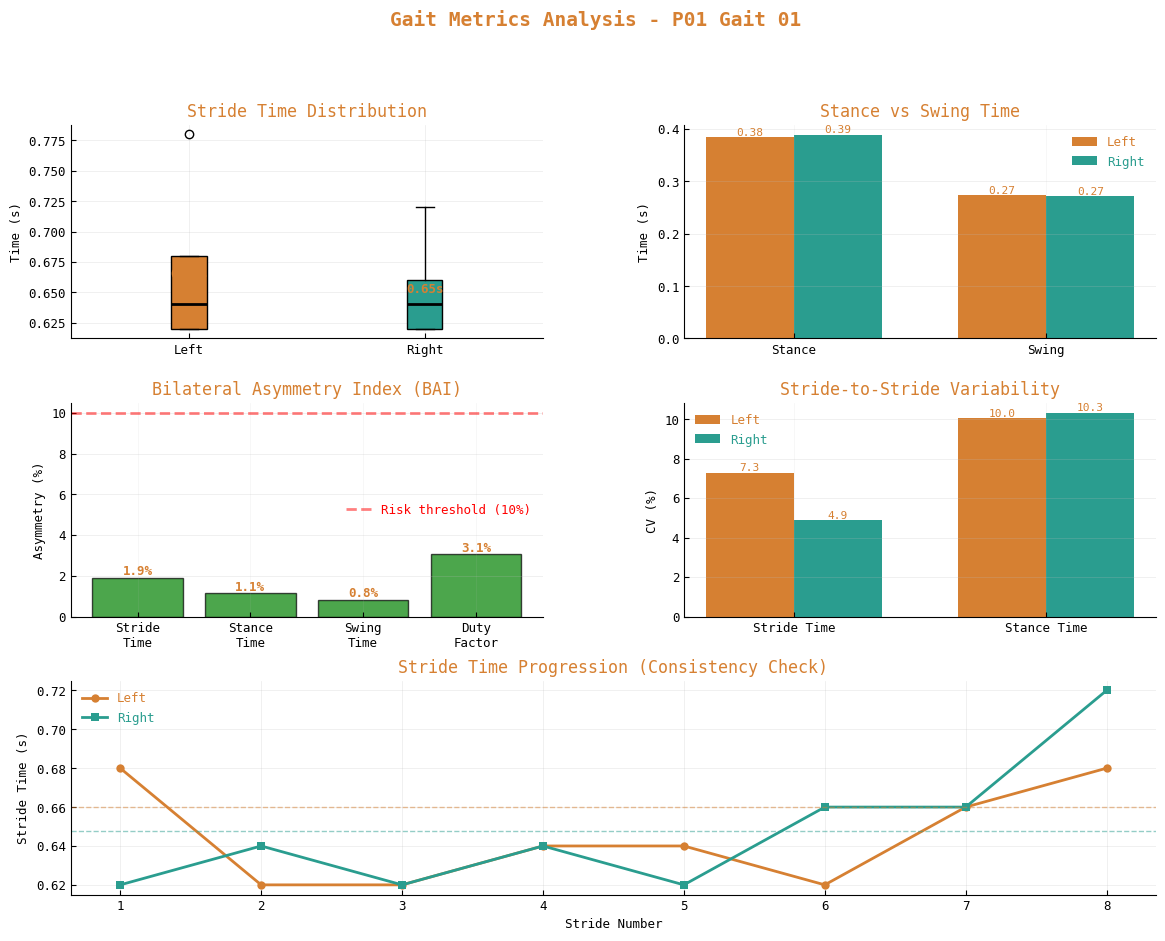


CLINICAL INTERPRETATION

📊 Performance Assessment:
   • Cadence: 90.9 steps/min
     (Walking: 100-120, Jogging: 160-180, Running: 180+)
   • Stride Time: 0.660s
     → This indicates FAST GAIT / LIGHT JOGGING pace
   • Duty Factor: L=0.58, R=0.60
     (Walking: 0.60-0.65, Transitional: 0.50-0.60, Running: <0.50)
     → Transitional between walking and running

⚠️  Injury Risk Assessment:
   ✓ LOW RISK: All asymmetries within normal limits (<10%)

📈 Variability:
   🔴 High variability (CV=6.1%) - Unstable gait pattern


In [301]:
# Create comprehensive visualization of metrics
fig = plt.figure(figsize=(14, 10))
gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)

# 1. Stride Time Comparison
ax1 = fig.add_subplot(gs[0, 0])
stride_data = [metrics_left['stride_times'], metrics_right['stride_times']]
bp1 = ax1.boxplot(stride_data, labels=['Left', 'Right'], patch_artist=True,
                   medianprops=dict(color='black', linewidth=2))
bp1['boxes'][0].set_facecolor(colours[0])
bp1['boxes'][1].set_facecolor(colours[1])
ax1.set_ylabel('Time (s)')
ax1.set_title('Stride Time Distribution')
ax1.grid(True, alpha=0.3)

# Add mean values as text
ax1.text(1, metrics_left['stride_time_mean'], f"{metrics_left['stride_time_mean']:.2f}s", 
         ha='center', va='bottom', fontsize=9, fontweight='bold')
ax1.text(2, metrics_right['stride_time_mean'], f"{metrics_right['stride_time_mean']:.2f}s", 
         ha='center', va='bottom', fontsize=9, fontweight='bold')

# 2. Stance vs Swing Time
ax2 = fig.add_subplot(gs[0, 1])
categories = ['Stance', 'Swing']
left_times = [metrics_left['stance_time_mean'], metrics_left['swing_time_mean']]
right_times = [metrics_right['stance_time_mean'], metrics_right['swing_time_mean']]

x = np.arange(len(categories))
width = 0.35
bars1 = ax2.bar(x - width/2, left_times, width, label='Left', color=colours[0])
bars2 = ax2.bar(x + width/2, right_times, width, label='Right', color=colours[1])

ax2.set_ylabel('Time (s)')
ax2.set_title('Stance vs Swing Time')
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom', fontsize=8)

# 3. Bilateral Asymmetry Index (BAI)
ax3 = fig.add_subplot(gs[1, 0])
metrics_names = ['Stride\nTime', 'Stance\nTime', 'Swing\nTime', 'Duty\nFactor']
bai_values = [
    asymmetry['stride_time_bai'],
    asymmetry['stance_time_bai'],
    asymmetry['swing_time_bai'],
    asymmetry['duty_factor_bai']
]
risk_flags = [
    asymmetry['stride_time_risk'],
    asymmetry['stance_time_risk'],
    asymmetry['swing_time_risk'],
    asymmetry['duty_factor_risk']
]

colors = ['red' if risk else 'green' for risk in risk_flags]
bars = ax3.bar(metrics_names, bai_values, color=colors, alpha=0.7, edgecolor='black')
ax3.axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Risk threshold (10%)')
ax3.set_ylabel('Asymmetry (%)')
ax3.set_title('Bilateral Asymmetry Index (BAI)')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# Add value labels
for bar, val in zip(bars, bai_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# 4. Coefficient of Variation (Variability)
ax4 = fig.add_subplot(gs[1, 1])
cv_metrics = ['Stride Time', 'Stance Time']
cv_left = [asymmetry['stride_time_cv_left'], asymmetry['stance_time_cv_left']]
cv_right = [asymmetry['stride_time_cv_right'], asymmetry['stance_time_cv_right']]

x = np.arange(len(cv_metrics))
width = 0.35
bars1 = ax4.bar(x - width/2, cv_left, width, label='Left', color=colours[0])
bars2 = ax4.bar(x + width/2, cv_right, width, label='Right', color=colours[1])

ax4.set_ylabel('CV (%)')
ax4.set_title('Stride-to-Stride Variability')
ax4.set_xticks(x)
ax4.set_xticklabels(cv_metrics)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}',
                ha='center', va='bottom', fontsize=8)

# 5. Stride Time Progression (Time Series)
ax5 = fig.add_subplot(gs[2, :])
min_len = min(len(metrics_left['stride_times']), len(metrics_right['stride_times']))
stride_indices = np.arange(1, min_len + 1)

ax5.plot(stride_indices, metrics_left['stride_times'][:min_len], 
         marker='o', label='Left', color=colours[0], linewidth=2, markersize=6)
ax5.plot(stride_indices, metrics_right['stride_times'][:min_len], 
         marker='s', label='Right', color=colours[1], linewidth=2, markersize=6)

# Add mean reference lines
ax5.axhline(y=metrics_left['stride_time_mean'], color=colours[0], 
           linestyle='--', linewidth=1, alpha=0.5)
ax5.axhline(y=metrics_right['stride_time_mean'], color=colours[1], 
           linestyle='--', linewidth=1, alpha=0.5)

ax5.set_xlabel('Stride Number')
ax5.set_ylabel('Stride Time (s)')
ax5.set_title('Stride Time Progression (Consistency Check)')
ax5.legend()
ax5.grid(True, alpha=0.3)

plt.suptitle(f'Gait Metrics Analysis - {participant} {trial} {trial_id}', 
             fontsize=14, fontweight='bold', y=0.995)

plt.show()

# Print interpretation
print("\n" + "=" * 70)
print("CLINICAL INTERPRETATION")
print("=" * 70)
print("\n📊 Performance Assessment:")
print(f"   • Cadence: {metrics_left['cadence']:.1f} steps/min")
print(f"     (Walking: 100-120, Jogging: 160-180, Running: 180+)")
print(f"   • Stride Time: {metrics_left['stride_time_mean']:.3f}s")
print(f"     → This indicates FAST GAIT / LIGHT JOGGING pace")
print(f"   • Duty Factor: L={metrics_left['duty_factor']:.2f}, R={metrics_right['duty_factor']:.2f}")
print(f"     (Walking: 0.60-0.65, Transitional: 0.50-0.60, Running: <0.50)")
print(f"     → Transitional between walking and running")

print("\n⚠️  Injury Risk Assessment:")
if asymmetry['risk_score'] == 0:
    print("   ✓ LOW RISK: All asymmetries within normal limits (<10%)")
elif asymmetry['risk_score'] <= 2:
    print("   ⚠️  MODERATE RISK: Some asymmetries detected")
    print("   • Consider monitoring for compensatory patterns")
    print("   • May benefit from targeted strength/mobility work")
else:
    print("   🔴 HIGH RISK: Multiple significant asymmetries detected")
    print("   • Recommend biomechanical assessment")
    print("   • Possible underlying weakness or injury")

print("\n📈 Variability:")
avg_cv = (asymmetry['stride_time_cv_left'] + asymmetry['stride_time_cv_right']) / 2
if avg_cv < 3:
    print(f"   ✓ Low variability (CV={avg_cv:.1f}%) - Consistent gait pattern")
elif avg_cv < 5:
    print(f"   ⚠️  Moderate variability (CV={avg_cv:.1f}%) - Some inconsistency")
else:
    print(f"   🔴 High variability (CV={avg_cv:.1f}%) - Unstable gait pattern")
print("=" * 70)

### 4.4 Advanced Metrics: Angular Velocity Analysis

In addition to temporal metrics, we can extract information from the gyroscope signals themselves to assess loading patterns and impact characteristics.


KINEMATIC METRICS (Loading & Impact)

Metric                                    Left Foot      Right Foot
----------------------------------------------------------------------
Peak Velocity at Toe-Off (deg/s)              403.3           352.4
Impact Velocity at Heel Strike (deg/s)            49.6            55.8
Range of Motion per Stride (deg/s)            747.5           690.7

----------------------------------------------------------------------

Kinematic Asymmetry (BAI %)                   Value            Risk
----------------------------------------------------------------------
Toe-Off Peak Velocity                         13.47              ⚠️
Heel Strike Impact Velocity                   11.75              ⚠️
Range of Motion                                7.90               ✓


/var/folders/6l/df10gbds78nfsxbyv01gwfsh0000gn/T/ipykernel_578/3213479586.py:89: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp1 = ax1.boxplot([kinematics_left['peak_velocities_FO'], kinematics_right['peak_velocities_FO']],
/var/folders/6l/df10gbds78nfsxbyv01gwfsh0000gn/T/ipykernel_578/3213479586.py:100: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp2 = ax2.boxplot([kinematics_left['impact_velocities_FC'], kinematics_right['impact_velocities_FC']],
/var/folders/6l/df10gbds78nfsxbyv01gwfsh0000gn/T/ipykernel_578/3213479586.py:111: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp3 = ax3.boxplot([kinematics_left['rom_

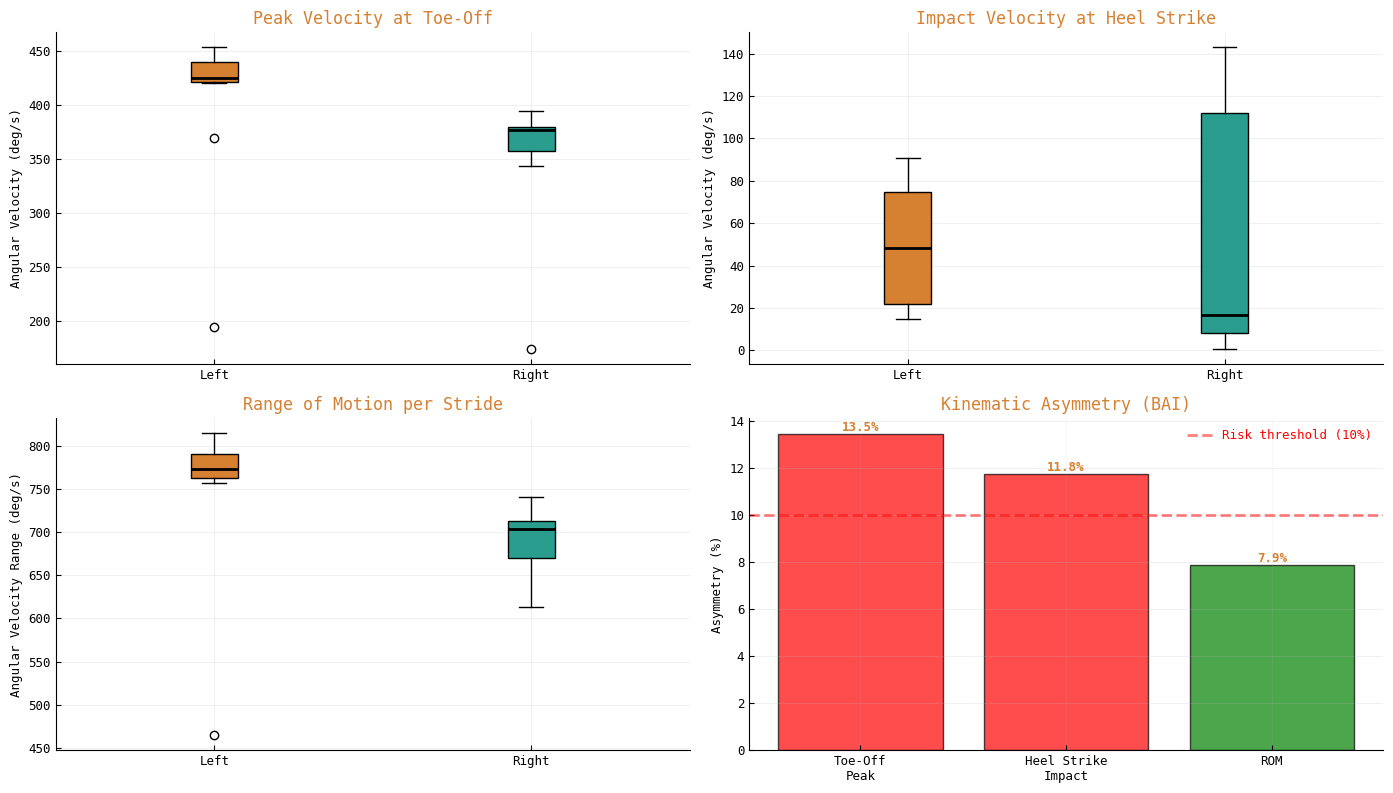


💡 Clinical Notes:
   • High peak velocity at toe-off indicates strong push-off power
   • Asymmetric impact velocities may suggest unequal loading or impact absorption
   • ROM asymmetry could indicate restricted mobility or compensatory patterns


In [269]:
def calculate_kinematic_metrics(signal, FC, FO):
    """
    Calculate kinematic metrics from gyroscope signal and gait events.
    
    Parameters:
    -----------
    signal : array
        Filtered gyroscope signal
    FC : array
        Foot contact indices
    FO : array
        Foot off indices
    
    Returns:
    --------
    dict : Dictionary containing kinematic metrics
    """
    metrics = {}
    
    # Peak angular velocity at toe-off (foot off events)
    peak_velocities_FO = []
    for fo in FO:
        # Get the angular velocity at foot off
        peak_velocities_FO.append(signal[fo])
    
    metrics['peak_velocity_FO_mean'] = np.mean(peak_velocities_FO)
    metrics['peak_velocity_FO_std'] = np.std(peak_velocities_FO)
    metrics['peak_velocities_FO'] = np.array(peak_velocities_FO)
    
    # Angular velocity at heel strike (foot contact events)
    impact_velocities_FC = []
    for fc in FC:
        # Get the angular velocity at foot contact
        impact_velocities_FC.append(abs(signal[fc]))
    
    metrics['impact_velocity_FC_mean'] = np.mean(impact_velocities_FC)
    metrics['impact_velocity_FC_std'] = np.std(impact_velocities_FC)
    metrics['impact_velocities_FC'] = np.array(impact_velocities_FC)
    
    # Range of motion (ROM) - difference between max and min in each stride
    rom_values = []
    for i in range(len(FC) - 1):
        stride_segment = signal[FC[i]:FC[i+1]]
        rom = np.max(stride_segment) - np.min(stride_segment)
        rom_values.append(rom)
    
    metrics['rom_mean'] = np.mean(rom_values)
    metrics['rom_std'] = np.std(rom_values)
    metrics['rom_values'] = np.array(rom_values)
    
    return metrics

# Calculate kinematic metrics for both feet
kinematics_left = calculate_kinematic_metrics(left_foot_filtered, FC_left, FO_left)
kinematics_right = calculate_kinematic_metrics(right_foot_filtered, FC_right, FO_right)

print("\n" + "=" * 70)
print("KINEMATIC METRICS (Loading & Impact)")
print("=" * 70)
print(f"\n{'Metric':<35} {'Left Foot':>15} {'Right Foot':>15}")
print("-" * 70)
print(f"{'Peak Velocity at Toe-Off (deg/s)':<35} {kinematics_left['peak_velocity_FO_mean']:>15.1f} {kinematics_right['peak_velocity_FO_mean']:>15.1f}")
print(f"{'Impact Velocity at Heel Strike (deg/s)':<35} {kinematics_left['impact_velocity_FC_mean']:>15.1f} {kinematics_right['impact_velocity_FC_mean']:>15.1f}")
print(f"{'Range of Motion per Stride (deg/s)':<35} {kinematics_left['rom_mean']:>15.1f} {kinematics_right['rom_mean']:>15.1f}")

# Calculate asymmetry in kinematic metrics
peak_velocity_bai = 100 * abs(kinematics_left['peak_velocity_FO_mean'] - kinematics_right['peak_velocity_FO_mean']) / \
                    ((kinematics_left['peak_velocity_FO_mean'] + kinematics_right['peak_velocity_FO_mean']) / 2)

impact_velocity_bai = 100 * abs(kinematics_left['impact_velocity_FC_mean'] - kinematics_right['impact_velocity_FC_mean']) / \
                      ((kinematics_left['impact_velocity_FC_mean'] + kinematics_right['impact_velocity_FC_mean']) / 2)

rom_bai = 100 * abs(kinematics_left['rom_mean'] - kinematics_right['rom_mean']) / \
          ((kinematics_left['rom_mean'] + kinematics_right['rom_mean']) / 2)

print("\n" + "-" * 70)
print(f"\n{'Kinematic Asymmetry (BAI %)':<35} {'Value':>15} {'Risk':>15}")
print("-" * 70)
print(f"{'Toe-Off Peak Velocity':<35} {peak_velocity_bai:>15.2f} {'⚠️' if peak_velocity_bai > 10 else '✓':>15}")
print(f"{'Heel Strike Impact Velocity':<35} {impact_velocity_bai:>15.2f} {'⚠️' if impact_velocity_bai > 10 else '✓':>15}")
print(f"{'Range of Motion':<35} {rom_bai:>15.2f} {'⚠️' if rom_bai > 10 else '✓':>15}")
print("=" * 70)

# Visualize kinematic metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Peak velocity at toe-off
ax1 = axes[0, 0]
bp1 = ax1.boxplot([kinematics_left['peak_velocities_FO'], kinematics_right['peak_velocities_FO']], 
                   labels=['Left', 'Right'], patch_artist=True,
                   medianprops=dict(color='black', linewidth=2))
bp1['boxes'][0].set_facecolor(colours[0])
bp1['boxes'][1].set_facecolor(colours[1])
ax1.set_ylabel('Angular Velocity (deg/s)')
ax1.set_title('Peak Velocity at Toe-Off')
ax1.grid(True, alpha=0.3)

# Impact velocity at heel strike
ax2 = axes[0, 1]
bp2 = ax2.boxplot([kinematics_left['impact_velocities_FC'], kinematics_right['impact_velocities_FC']], 
                   labels=['Left', 'Right'], patch_artist=True,
                   medianprops=dict(color='black', linewidth=2))
bp2['boxes'][0].set_facecolor(colours[0])
bp2['boxes'][1].set_facecolor(colours[1])
ax2.set_ylabel('Angular Velocity (deg/s)')
ax2.set_title('Impact Velocity at Heel Strike')
ax2.grid(True, alpha=0.3)

# Range of motion
ax3 = axes[1, 0]
bp3 = ax3.boxplot([kinematics_left['rom_values'], kinematics_right['rom_values']], 
                   labels=['Left', 'Right'], patch_artist=True,
                   medianprops=dict(color='black', linewidth=2))
bp3['boxes'][0].set_facecolor(colours[0])
bp3['boxes'][1].set_facecolor(colours[1])
ax3.set_ylabel('Angular Velocity Range (deg/s)')
ax3.set_title('Range of Motion per Stride')
ax3.grid(True, alpha=0.3)

# Kinematic asymmetry summary
ax4 = axes[1, 1]
metrics_names = ['Toe-Off\nPeak', 'Heel Strike\nImpact', 'ROM']
bai_values = [peak_velocity_bai, impact_velocity_bai, rom_bai]
colors = ['red' if bai > 10 else 'green' for bai in bai_values]

bars = ax4.bar(metrics_names, bai_values, color=colors, alpha=0.7, edgecolor='black')
ax4.axhline(y=10, color='red', linestyle='--', linewidth=2, alpha=0.5, label='Risk threshold (10%)')
ax4.set_ylabel('Asymmetry (%)')
ax4.set_title('Kinematic Asymmetry (BAI)')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, bai_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n💡 Clinical Notes:")
print("   • High peak velocity at toe-off indicates strong push-off power")
print("   • Asymmetric impact velocities may suggest unequal loading or impact absorption")
print("   • ROM asymmetry could indicate restricted mobility or compensatory patterns")

### 4.5 Summary Report

Generate a comprehensive summary report combining all metrics for clinical assessment.

In [ ]:
def generate_gait_report(participant, trial, trial_id, metrics_left, metrics_right, 
                        asymmetry, kinematics_left, kinematics_right):
    """
    Generate a comprehensive gait analysis report.
    """
    
    # Calculate additional kinematic asymmetries
    peak_velocity_bai = 100 * abs(kinematics_left['peak_velocity_FO_mean'] - kinematics_right['peak_velocity_FO_mean']) / \
                        ((kinematics_left['peak_velocity_FO_mean'] + kinematics_right['peak_velocity_FO_mean']) / 2)
    impact_velocity_bai = 100 * abs(kinematics_left['impact_velocity_FC_mean'] - kinematics_right['impact_velocity_FC_mean']) / \
                          ((kinematics_left['impact_velocity_FC_mean'] + kinematics_right['impact_velocity_FC_mean']) / 2)
    rom_bai = 100 * abs(kinematics_left['rom_mean'] - kinematics_right['rom_mean']) / \
              ((kinematics_left['rom_mean'] + kinematics_right['rom_mean']) / 2)
    
    # Extended risk score including kinematic asymmetries
    kinematic_risk = sum([peak_velocity_bai > 10, impact_velocity_bai > 10, rom_bai > 10])
    total_risk_score = asymmetry['risk_score'] + kinematic_risk
    
    print("\n" + "=" * 80)
    print(f"{'GAIT ANALYSIS REPORT':^80}")
    print("=" * 80)
    print(f"Participant: {participant} | Trial: {trial} {trial_id}")
    print(f"Date: 3 October 2025")
    print("=" * 80)
    
    print("\n📊 PERFORMANCE METRICS")
    print("-" * 80)
    print(f"  Cadence:                {metrics_left['cadence']:.1f} steps/min")
    # Interpret gait speed based on stride time and duty factor
    stride_time_avg = (metrics_left['stride_time_mean'] + metrics_right['stride_time_mean']) / 2
    duty_factor_avg = (metrics_left['duty_factor'] + metrics_right['duty_factor']) / 2
    if stride_time_avg > 0.9:
        pace_description = "SLOW WALKING"
    elif stride_time_avg > 0.7:
        pace_description = "NORMAL WALKING"
    elif stride_time_avg > 0.5:
        pace_description = "FAST WALKING"
    elif stride_time_avg > 0.35:
        pace_description = "LIGHT JOGGING" if duty_factor_avg > 0.50 else "JOGGING"
    else:
        pace_description = "RUNNING"
    print(f"  Pace Classification:    {pace_description} (stride time: {stride_time_avg:.3f}s)")
    print(f"  Stride Time:            L={metrics_left['stride_time_mean']:.3f}s  R={metrics_right['stride_time_mean']:.3f}s")
    print(f"  Stance/Swing Ratio:     L={metrics_left['stance_swing_ratio']:.2f}  R={metrics_right['stance_swing_ratio']:.2f}")
    print(f"  Duty Factor:            L={metrics_left['duty_factor']:.3f}  R={metrics_right['duty_factor']:.3f}")
    
    print("\n⚠️  INJURY RISK INDICATORS")
    print("-" * 80)
    print(f"  Temporal Asymmetries:")
    print(f"    • Stride Time:        {asymmetry['stride_time_bai']:.2f}%  {'⚠️ RISK' if asymmetry['stride_time_risk'] else '✓ OK'}")
    print(f"    • Stance Time:        {asymmetry['stance_time_bai']:.2f}%  {'⚠️ RISK' if asymmetry['stance_time_risk'] else '✓ OK'}")
    print(f"    • Swing Time:         {asymmetry['swing_time_bai']:.2f}%  {'⚠️ RISK' if asymmetry['swing_time_risk'] else '✓ OK'}")
    print(f"    • Duty Factor:        {asymmetry['duty_factor_bai']:.2f}%  {'⚠️ RISK' if asymmetry['duty_factor_risk'] else '✓ OK'}")
    
    print(f"\n  Kinematic Asymmetries:")
    print(f"    • Toe-Off Peak:       {peak_velocity_bai:.2f}%  {'⚠️ RISK' if peak_velocity_bai > 10 else '✓ OK'}")
    print(f"    • Heel Strike Impact: {impact_velocity_bai:.2f}%  {'⚠️ RISK' if impact_velocity_bai > 10 else '✓ OK'}")
    print(f"    • Range of Motion:    {rom_bai:.2f}%  {'⚠️ RISK' if rom_bai > 10 else '✓ OK'}")
    
    avg_cv = (asymmetry['stride_time_cv_left'] + asymmetry['stride_time_cv_right']) / 2
    print(f"\n  Gait Variability:")
    print(f"    • Stride Time CV:     {avg_cv:.2f}%  ", end="")
    if avg_cv < 3:
        print("✓ Low (Consistent)")
    elif avg_cv < 5:
        print("⚠️ Moderate")
    else:
        print("🔴 High (Unstable)")
    
    print("\n" + "=" * 80)
    print(f"OVERALL RISK ASSESSMENT: {total_risk_score}/7 metrics exceed thresholds")
    print("-" * 80)
    
    if total_risk_score == 0:
        risk_level = "LOW"
        symbol = "✓"
        recommendation = "Gait pattern within normal limits. Continue regular training."
    elif total_risk_score <= 2:
        risk_level = "MODERATE"
        symbol = "⚠️"
        recommendation = "Minor asymmetries detected. Monitor for changes and consider\n" + \
                        " " * 22 + "preventive strengthening exercises."
    elif total_risk_score <= 4:
        risk_level = "ELEVATED"
        symbol = "⚠️"
        recommendation = "Multiple asymmetries present. Recommend biomechanical assessment\n" + \
                        " " * 22 + "and targeted intervention (strength, mobility, technique)."
    else:
        risk_level = "HIGH"
        symbol = "🔴"
        recommendation = "Significant asymmetries detected. Clinical evaluation recommended.\n" + \
                        " " * 22 + "Possible underlying weakness, injury, or compensatory pattern."
    
    print(f"  Risk Level:        {symbol} {risk_level}")
    print(f"  Recommendation:    {recommendation}")
    print("=" * 80)
    
    return {
        'total_risk_score': total_risk_score,
        'risk_level': risk_level,
        'peak_velocity_bai': peak_velocity_bai,
        'impact_velocity_bai': impact_velocity_bai,
        'rom_bai': rom_bai
    }

# Generate comprehensive report
report = generate_gait_report(participant, trial, trial_id, 
                              metrics_left, metrics_right, 
                              asymmetry, kinematics_left, kinematics_right)


                              GAIT ANALYSIS REPORT                              
Participant: P01 | Trial: Gait 01
Date: 3 October 2025

📊 PERFORMANCE METRICS
--------------------------------------------------------------------------------
  Cadence:                181.2 steps/min
  Stride Time:            L=0.331s  R=0.325s
  Stance/Swing Ratio:     L=1.39  R=1.42
  Duty Factor:            L=0.577  R=0.598

⚠️  INJURY RISK INDICATORS
--------------------------------------------------------------------------------
  Temporal Asymmetries:
    • Stride Time:        1.86%  ✓ OK
    • Stance Time:        1.73%  ✓ OK
    • Swing Time:         0.81%  ✓ OK
    • Duty Factor:        3.59%  ✓ OK

  Kinematic Asymmetries:
    • Toe-Off Peak:       13.47%  ⚠️ RISK
    • Heel Strike Impact: 11.75%  ⚠️ RISK
    • Range of Motion:    7.90%  ✓ OK

  Gait Variability:
    • Stride Time CV:     6.36%  🔴 High (Unstable)

OVERALL RISK ASSESSMENT: 2/7 metrics exceed thresholds
---------------------------